In [1]:
'''
author: EdgardoCS @FSU Jena
date: 18.06.2025
'''

# install openpyxl

import bambi as bmb
import arviz as az
import itertools
import pingouin as pg
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.genmod as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap

pd.set_option('future.no_silent_downcasting', True)

In [2]:
input_data = 'output/data_sorted.xlsx'
columns = ['Id', 'Age', 'Rating', 'Gender', 'Segment', 'Location', 'Type']

data = pd.read_excel(input_data, usecols=columns)

# focus on Female and Male for now
data = (data[data['Gender'].isin(['Female', 'Male'])]).reset_index()

In [3]:
data.loc[(data['Segment'] == "Face") & (data['Location'] == "Back"), 'Segment'] = "Head"
data.loc[(data['Segment'] == "Genitals") & (data['Location'] == "Back"), 'Segment'] = "Buttocks"
data.loc[(data['Segment'] == "Chest") & (data['Location'] == "Back"), 'Segment'] = "Back"

In [4]:
n = len(data["Id"].unique())
# print(n)
# 2409 subjects

In [5]:
data["Segment"].value_counts()

Segment
Armpits     6549
Feet        4408
Neck        2798
Genitals    2691
Hands       2404
Face        2186
Buttocks    1808
Chest       1068
Head         999
Back         822
Legs         579
Name: count, dtype: int64

In [6]:
# data["Location"].value_counts()

In [7]:
# data["Type"].value_counts()

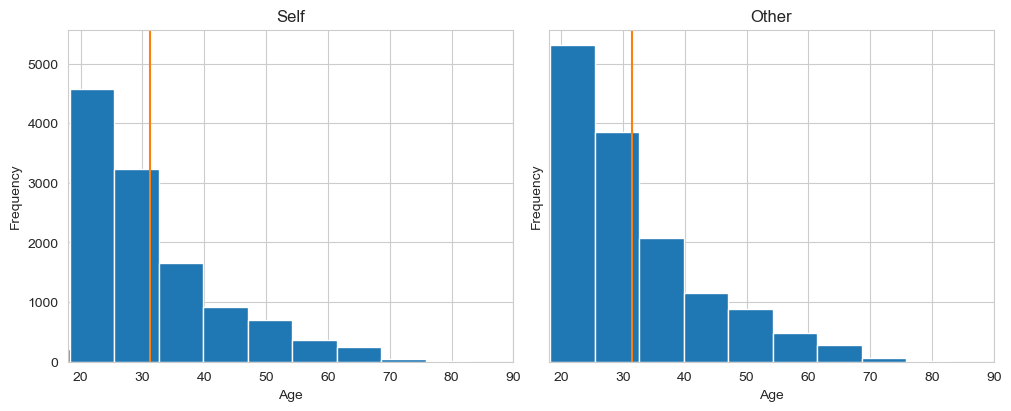

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["Type"].unique(), range(3)))
for label, df in data.groupby("Type"):
    ax[key[label]].hist(df["Age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["Age"].mean(), color="C1")
plt.savefig('output/distribution_age.png', dpi=350, bbox_inches='tight')

In [9]:
# Define all factor levels
types = data["Type"].unique()
segments = data["Segment"].unique()
genders = data["Gender"].unique()

In [10]:
import math

# Build full grid for each subject × all combinations of the 3 factors
all_combos = pd.DataFrame([
    (i, g, t)
    for i in data['Id'].unique()
    for g, t, in itertools.product(types, segments)
], columns=['Id', 'Type', 'Segment'])

#
# Merge data with all possible combinations
merged = all_combos.merge(
    data[['Id', 'Type', 'Segment', 'Rating']],
    on=['Id', 'Type', 'Segment'],
    how='left'
)
merged.loc[pd.isna(merged['Rating']), 'Rating'] = 0

In [11]:
merged['Rating'] = pd.to_numeric(merged['Rating'], errors='coerce')
merged = merged.loc[merged.groupby(['Id', 'Type', 'Segment'])['Rating'].idxmax()].reset_index(drop=True)

# # Add indicator of whether that combination was rated
merged['Marked'] = (merged['Rating'] > 0).astype(int)

In [12]:
merged = pd.merge(merged, data.drop_duplicates(subset=['Id', 'Segment', 'Type'], keep='first')[
    ['Id', 'Segment', 'Type', 'Age', 'Gender']],
                  on=['Id', 'Segment', 'Type'],
                  how='left')

In [13]:
merged['Age'] = merged.groupby('Id')['Age'].transform(lambda x: x.ffill().bfill())
merged['Gender'] = merged.groupby('Id')['Gender'].transform(lambda x: x.ffill().bfill())

In [14]:
female_df = merged[merged['Gender'] == 'Female'].copy()
male_df = merged[merged['Gender'] == 'Male'].copy()

In [15]:
female_n = len(female_df["Id"].unique())
male_n = len(male_df["Id"].unique())
print('females', female_n)
print('males', male_n)

females 1524
males 885


In [16]:
# pd.crosstab(female_df["Segment"], female_df["Marked"])
pd.crosstab(
    index=female_df["Segment"],
    columns=[female_df["Marked"]]
)

Marked,0,1
Segment,,
Armpits,195,2853
Back,2554,494
Buttocks,1925,1123
Chest,2353,695
Face,1606,1442
Feet,1164,1884
Genitals,1288,1760
Hands,1912,1136
Head,2361,687


In [17]:
# pd.crosstab(male_df["Segment"], male_df["Marked"])
pd.crosstab(
    index=male_df["Segment"],
    columns=[male_df["Marked"]]
)

Marked,0,1
Segment,,
Armpits,177,1593
Back,1442,328
Buttocks,1085,685
Chest,1397,373
Face,1026,744
Feet,798,972
Genitals,839,931
Hands,1221,549
Head,1458,312


In [18]:
# For Pie charts
colors = sns.color_palette('YlGnBu_d')[1:3]

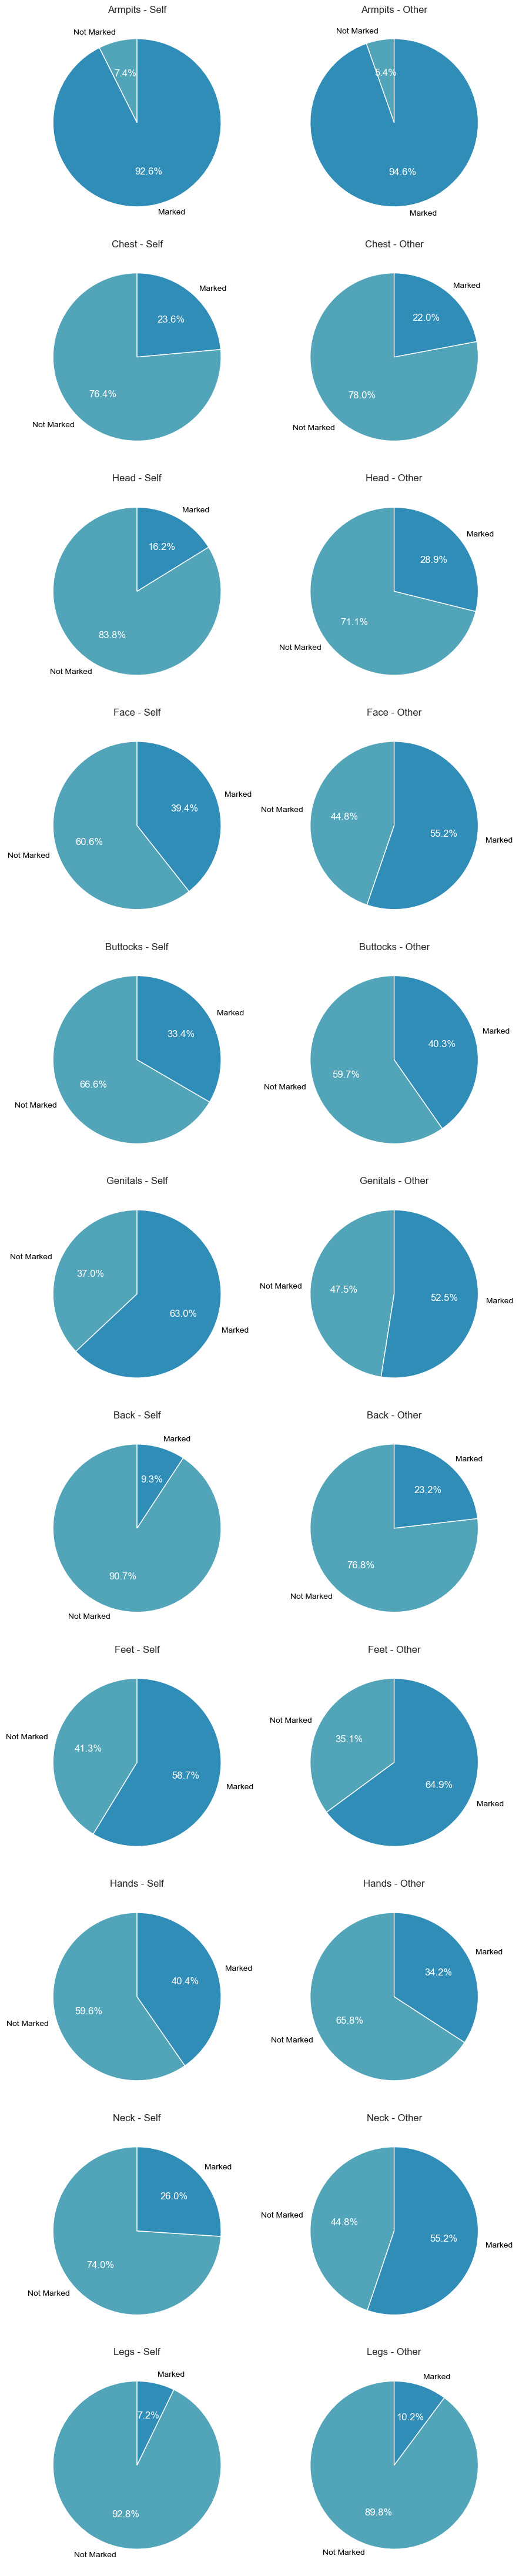

In [19]:
# Setup grid of subplots
fig, axes = plt.subplots(nrows=len(segments), ncols=len(types), figsize=(8 * len(types), 4 * len(segments)))
plt.tight_layout()

# Make sure axes is always 2D
if len(segments) == 1:
    axes = [axes]
if len(types) == 1:
    axes = [[ax] for ax in axes]

# Plot
for i, segment in enumerate(segments):
    for j, type in enumerate(types):
        ax = axes[i][j]
        subset = female_df[(female_df["Segment"] == segment) & (female_df["Type"] == type)]
        counts = subset["Marked"].value_counts().sort_index()

        labels = ["Not Marked", "Marked"]
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            textprops={"color": "black"},
            colors=colors
        )

        # Set percentage text to white inside slices
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontsize("large")
        ax.set_title(f"{segment} - {type}")

fig.subplots_adjust(wspace=-0.6)
plt.savefig('output/pie-female.png', dpi=350, bbox_inches='tight')
plt.show()

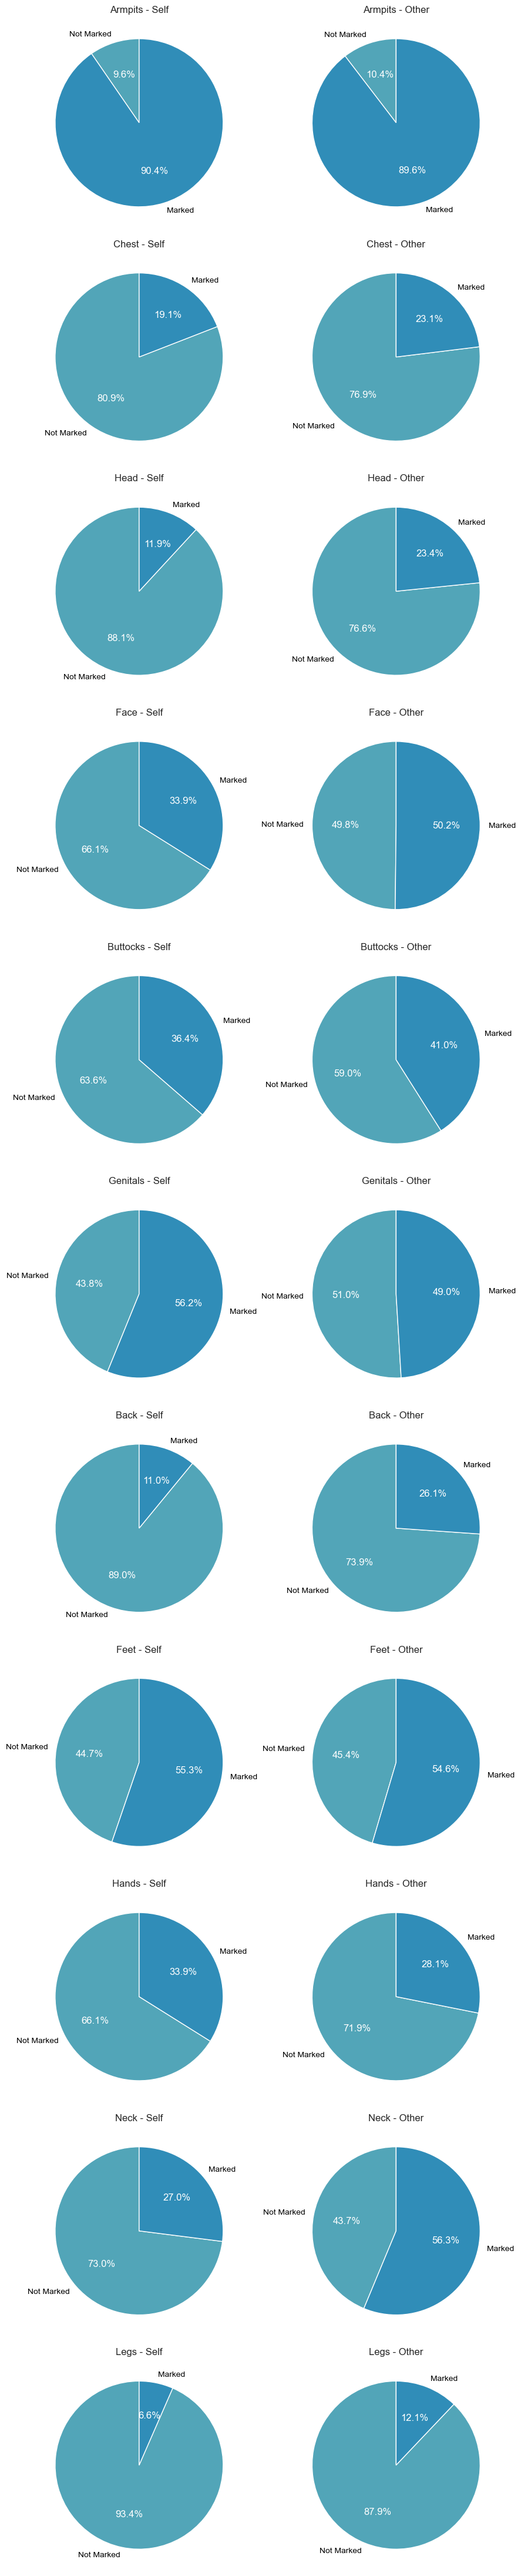

In [20]:
# Setup grid of subplots
fig, axes = plt.subplots(nrows=len(segments), ncols=len(types), figsize=(8 * len(types), 4 * len(segments)))
plt.tight_layout()

# Make sure axes is always 2D
if len(segments) == 1:
    axes = [axes]
if len(types) == 1:
    axes = [[ax] for ax in axes]

# Plot
for i, segment in enumerate(segments):
    for j, type in enumerate(types):
        ax = axes[i][j]
        subset = male_df[(male_df["Segment"] == segment) & (male_df["Type"] == type)]
        counts = subset["Marked"].value_counts().sort_index()

        labels = ["Not Marked", "Marked"]
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=labels,
            autopct="%1.1f%%",
            startangle=90,
            textprops={"color": "black"},
            colors=colors
        )

        # Set percentage text to white inside slices
        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontsize("large")
        ax.set_title(f"{segment} - {type}")

fig.subplots_adjust(wspace=-0.6)
plt.savefig('output/pie-male.png', dpi=350, bbox_inches='tight')
plt.show()

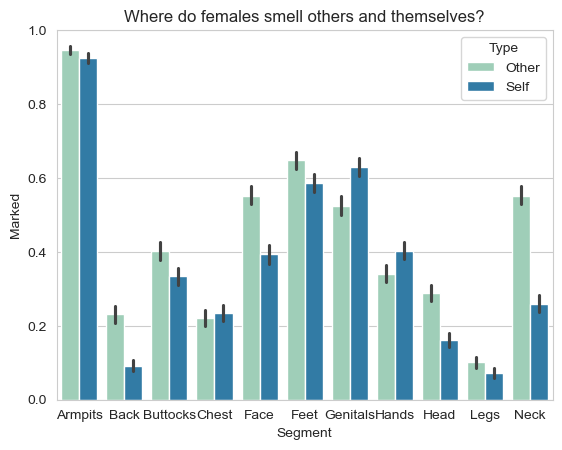

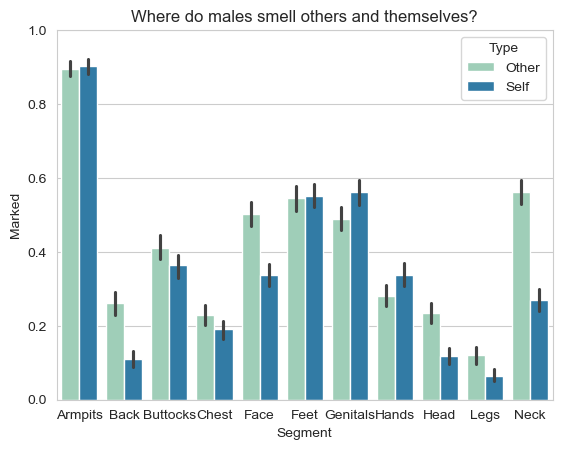

In [21]:
sns.barplot(
    data=merged[merged['Gender'] == 'Female'],
    hue="Type",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do females smell others and themselves?')
plt.savefig('output/bars-female.png', dpi=350, bbox_inches='tight')
plt.show()

sns.barplot(
    data=merged[merged['Gender'] == 'Male'],
    hue="Type",
    x="Segment",
    y="Marked",
    palette='YlGnBu'
)
plt.ylim(0, 1)
plt.title('Where do males smell others and themselves?')
plt.savefig('output/bars-male.png', dpi=350, bbox_inches='tight')
plt.show()

In [22]:
# sns.barplot(
#     data=female_df[female_df['Type'] == 'Other'],
#     hue="Location",
#     x="Segment",
#     y="Marked",
#     palette='YlGnBu'
# )
# plt.ylim(0, 1)
# plt.title('Where do females smell others?')
# plt.savefig('output/bars-female-others.png', dpi=350, bbox_inches='tight')
# plt.show()
#
# sns.barplot(
#     data=male_df[male_df['Type'] == 'Other'],
#     hue="Location",
#     x="Segment",
#     y="Marked",
#     palette='YlGnBu'
# )
# plt.ylim(0, 1)
# plt.title('Where do males smell others?')
# plt.savefig('output/bars-male-others.png', dpi=350, bbox_inches='tight')
# plt.show()

In [23]:
colors = [sns.color_palette('YlGnBu_d')[0], sns.color_palette('YlGnBu_d')[3]]

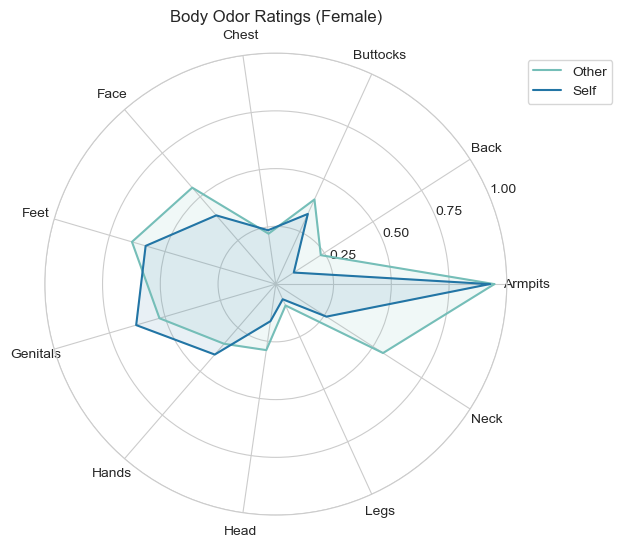

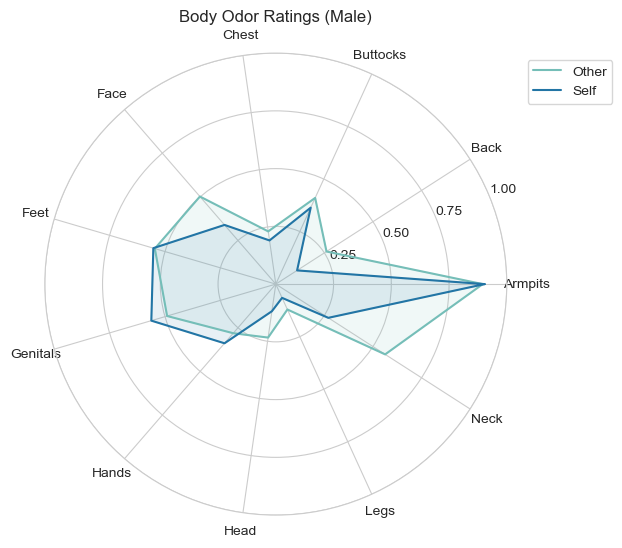

In [24]:
all_radar = merged.groupby(['Segment', 'Gender', 'Type'])['Marked']
estimates = all_radar.mean().reset_index()
estimates = estimates.rename(columns={'Marked': 'Mean_Marked'})

for i, t in enumerate(genders):
    pivot_df = estimates[estimates['Gender'] == t].pivot(
        index='Type',
        columns='Segment',
        values='Mean_Marked'
    )
    categories = list(pivot_df.columns)
    N = len(categories)

    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in pivot_df.iterrows():
        values = row.tolist()
        values += values[:1]
        if idx == "Other":
            ax.plot(angles, values, label=idx, color=colors[0])
            ax.fill(angles, values, alpha=0.1, color=colors[0])
        elif idx == "Self":
            ax.plot(angles, values, label=idx, color=colors[1])
            ax.fill(angles, values, alpha=0.1, color=colors[1])

    ticks = [0.25, 0.50, 0.75, 1]
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_yticks(ticks)
    ax.set_title(f'Body Odor Ratings ({t})')
    ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
    plt.savefig('output/radar-' + t + '.png', dpi=350, bbox_inches='tight')
    plt.show()

In [31]:
female_density = (
    female_df.groupby(['Id', 'Type', 'Age'])['Marked'].value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: 'Unmarked', 1: 'Marked'})
    .reset_index()
)

female_wide = female_density.pivot(index='Id', columns=['Type'], values='Marked')

age_map = female_density.groupby('Id')['Age'].first()
female_wide['Age'] = female_wide.index.map(age_map)

# print('female cronbach', pg.cronbach_alpha(data=female_wide))
#
male_density = (
    male_df.groupby(['Id', 'Type', 'Age'])['Marked'].value_counts()
    .unstack(fill_value=0)
    .rename(columns={0: 'Unmarked', 1: 'Marked'})
    .reset_index()
)

male_wide = male_density.pivot(index='Id', columns=['Type'], values='Marked')
age_map = male_density.groupby('Id')['Age'].first()
male_wide['Age'] = male_wide.index.map(age_map)

# print('male cronbach', pg.cronbach_alpha(data=male_wide))

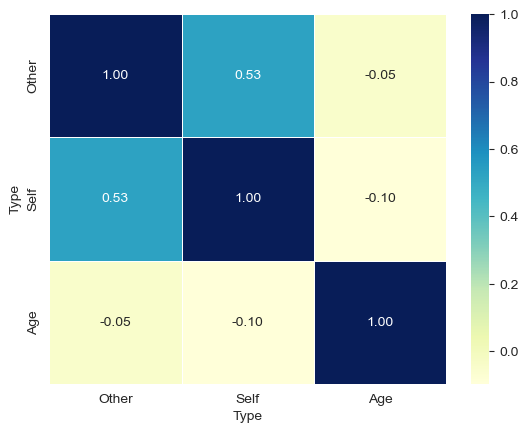

In [30]:
correlation = female_wide.corr()
sns.heatmap(correlation, cmap='YlGnBu', fmt='.2f',
            linewidths=0.5, annot_kws={"size": 10},
            annot=True,
            )
plt.grid(False)

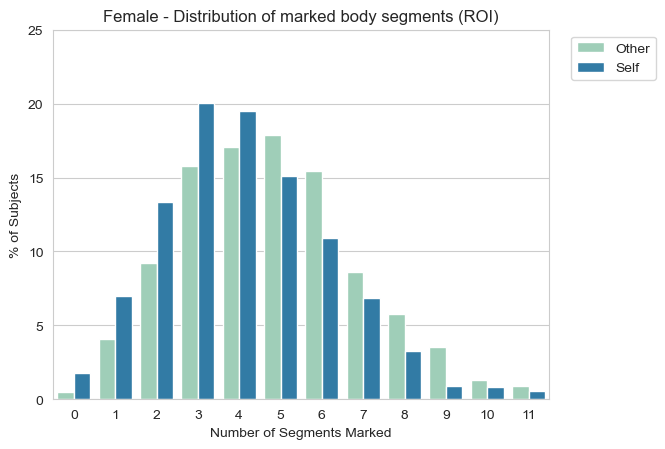

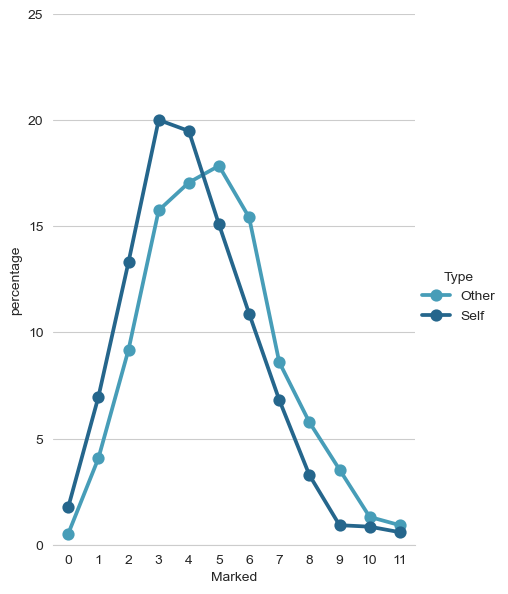

In [40]:
female_distribution = female_density.groupby(['Type'], as_index=False)['Marked'].value_counts()
female_distribution["percentage"] = round(female_distribution['count'].transform(lambda x: x * 100 / female_n), 2)

sns.barplot(data=female_distribution, x="Marked", y="percentage", hue='Type',
            palette='YlGnBu')
plt.xlabel("Number of Segments Marked")
plt.ylabel("% of Subjects")
plt.ylim([0, 25])
plt.title("Female - Distribution of marked body segments (ROI)")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/histo-female-marked.png', dpi=350, bbox_inches='tight')
plt.show()

g = sns.catplot(
    data=female_distribution, x="Marked", y="percentage", hue="Type",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.ylim([0, 25])
plt.savefig('output/cat-female-marked.png', dpi=350, bbox_inches='tight')
plt.show()

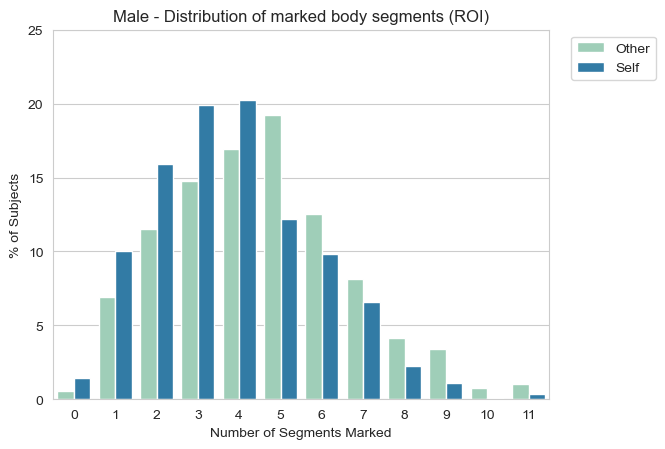

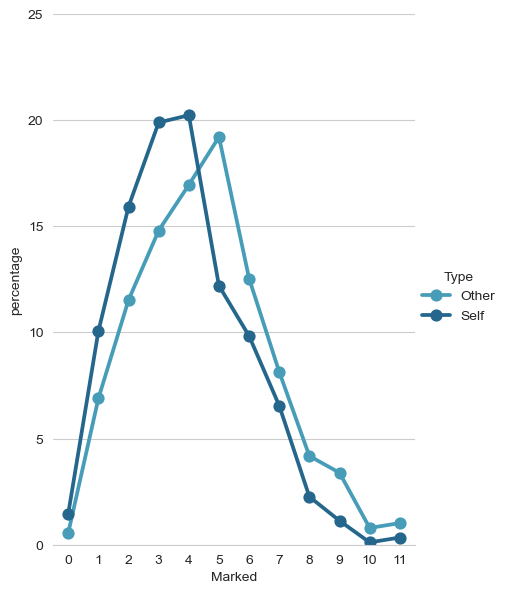

In [41]:
male_distribution = male_density.groupby(['Type'], as_index=False)['Marked'].value_counts()
male_distribution["percentage"] = round(male_distribution['count'].transform(lambda x: x * 100 / male_n), 2)

sns.barplot(data=male_distribution, x="Marked", y="percentage", hue="Type",
            palette='YlGnBu')
plt.xlabel("Number of Segments Marked")
plt.ylabel("% of Subjects")
plt.ylim([0, 25])
plt.title("Male - Distribution of marked body segments (ROI)")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('output/histo-male-marked.png', dpi=350, bbox_inches='tight')
plt.show()

g = sns.catplot(
    data=male_distribution, x="Marked", y="percentage", hue="Type",
    capsize=.2, palette="YlGnBu_d", errorbar="se",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
plt.ylim([0, 25])
plt.savefig('output/cat-male-marked.png', dpi=350, bbox_inches='tight')
plt.show()

In [60]:
_none = [0]
_low = [1, 2, 3]
_med = [4, 5, 6, 7]
_high = [8, 9, 10, 11]

In [100]:
temp_none1 = []
temp_low1 = []
temp_med1 = []
temp_high1 = []
temp_none2 = []
temp_low2 = []
temp_med2 = []
temp_high2 = []

temp = female_density[female_density['Type'] == 'Self'].copy()
temp = temp.reset_index(drop=True)

for i, x in enumerate(temp["Id"]):
    if temp["Marked"][i] in _none:
        temp_none1.append(temp["Id"][i])
    elif temp["Marked"][i] in _low:
        temp_low1.append(temp["Id"][i])
    elif temp["Marked"][i] in _med:
        temp_med1.append(temp["Id"][i])
    elif temp["Marked"][i] in _high:
        temp_high1.append(temp["Id"][i])

temp = female_density[female_density['Type'] == 'Other'].copy()
temp = temp.reset_index(drop=True)

for i, x in enumerate(temp["Id"]):
    if temp["Marked"][i] in _none:
        temp_none2.append(temp["Id"][i])
    elif temp["Marked"][i] in _low:
        temp_low2.append(temp["Id"][i])
    elif temp["Marked"][i] in _med:
        temp_med2.append(temp["Id"][i])
    elif temp["Marked"][i] in _high:
        temp_high2.append(temp["Id"][i])

conditions = [
    (female_df['Id'].isin(temp_none1)) & (female_df['Type'] == "Self"),
    (female_df['Id'].isin(temp_low1)) & (female_df['Type'] == "Self"),
    (female_df['Id'].isin(temp_med1)) & (female_df['Type'] == "Self"),
    (female_df['Id'].isin(temp_high1)) & (female_df['Type'] == "Self"),
    (female_df['Id'].isin(temp_none2)) & (female_df['Type'] == "Other"),
    (female_df['Id'].isin(temp_low2)) & (female_df['Type'] == "Other"),
    (female_df['Id'].isin(temp_med2)) & (female_df['Type'] == "Other"),
    (female_df['Id'].isin(temp_high2)) & (female_df['Type'] == "Other"),
]

choices = ["None", "Low", "Medium", "High", "None", "Low", "Medium", "High"]

female_df['Group'] = np.select(conditions, choices, default=False)

In [101]:
temp_none1 = []
temp_low1 = []
temp_med1 = []
temp_high1 = []
temp_none2 = []
temp_low2 = []
temp_med2 = []
temp_high2 = []

temp = male_density[male_density['Type'] == 'Self'].copy()
temp = temp.reset_index(drop=True)

for i, x in enumerate(temp["Id"]):
    if temp["Marked"][i] in _none:
        temp_none1.append(temp["Id"][i])
    elif temp["Marked"][i] in _low:
        temp_low1.append(temp["Id"][i])
    elif temp["Marked"][i] in _med:
        temp_med1.append(temp["Id"][i])
    elif temp["Marked"][i] in _high:
        temp_high1.append(temp["Id"][i])

temp = male_density[male_density['Type'] == 'Other'].copy()
temp = temp.reset_index(drop=True)

for i, x in enumerate(temp["Id"]):
    if temp["Marked"][i] in _none:
        temp_none2.append(temp["Id"][i])
    elif temp["Marked"][i] in _low:
        temp_low2.append(temp["Id"][i])
    elif temp["Marked"][i] in _med:
        temp_med2.append(temp["Id"][i])
    elif temp["Marked"][i] in _high:
        temp_high2.append(temp["Id"][i])

conditions = [
    (male_df['Id'].isin(temp_none1)) & (male_df['Type'] == "Self"),
    (male_df['Id'].isin(temp_low1)) & (male_df['Type'] == "Self"),
    (male_df['Id'].isin(temp_med1)) & (male_df['Type'] == "Self"),
    (male_df['Id'].isin(temp_high1)) & (male_df['Type'] == "Self"),
    (male_df['Id'].isin(temp_none2)) & (male_df['Type'] == "Other"),
    (male_df['Id'].isin(temp_low2)) & (male_df['Type'] == "Other"),
    (male_df['Id'].isin(temp_med2)) & (male_df['Type'] == "Other"),
    (male_df['Id'].isin(temp_high2)) & (male_df['Type'] == "Other"),
]

choices = ["None", "Low", "Medium", "High", "None", "Low", "Medium", "High"]

male_df['Group'] = np.select(conditions, choices, default=False)

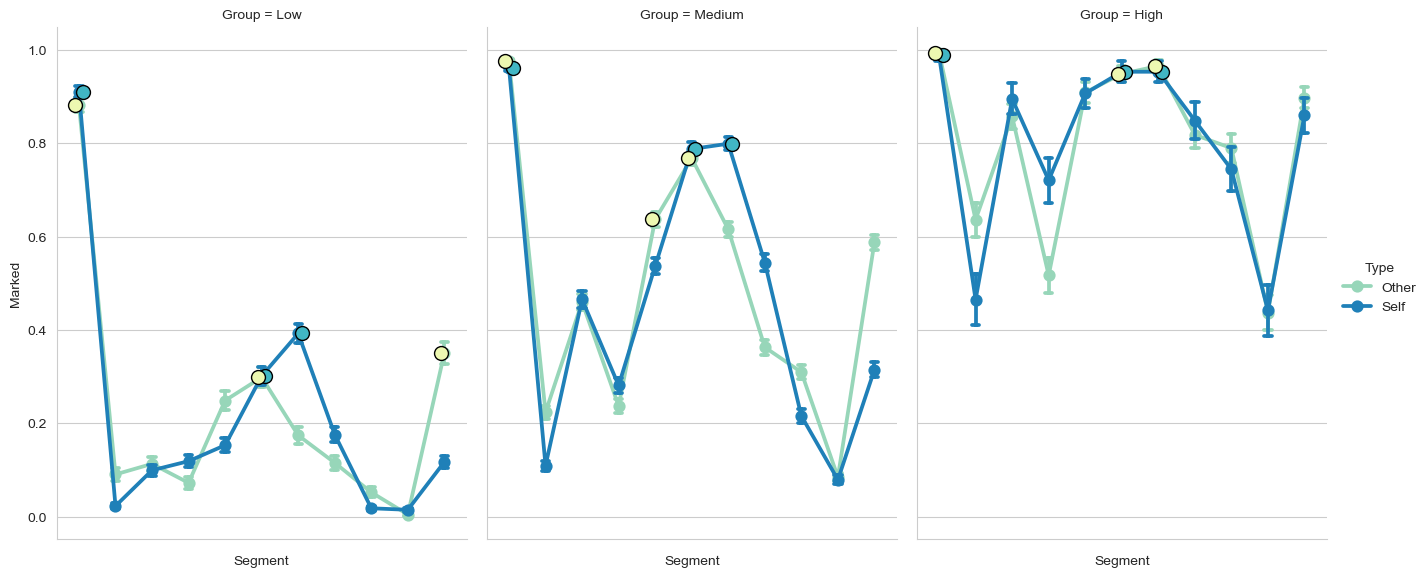

In [302]:
female_df = female_df[female_df["Group"] != "None"].copy()

g = sns.catplot(
    data=female_df, x="Segment", y="Marked", hue="Type", col="Group",
    capsize=.2, palette="YlGnBu", errorbar="se",
    kind="point", height=6, aspect=.75,
    col_order=["Low", "Medium", "High"],
)

xtick_position = []
xtick_label = []

segment_order = list(female_df["Segment"].unique())

for ax, group_name in zip(g.axes.flat, ["Low", "Medium", "High"]):
    group_data = female_df[female_df["Group"] == group_name]
    segments_to_keep = set()

    for type_name, color, offset in [("Self", '#41b6c4', 0.1), ("Other", '#edf8b1', -0.1)]:
        type_data = group_data[group_data["Type"] == type_name]

        avg_data = (
            type_data
            .groupby(["Segment", "Type"], as_index=False)["Marked"]
            .mean()
        )

        top3 = avg_data.nlargest(3, "Marked")

        for _, row in top3.iterrows():
            segment = row["Segment"]
            y = row["Marked"]
            x = segment_order.index(segment)
            ax.plot(x + offset, y, 'o', color=color, markeredgecolor='k',
                    markersize=10, zorder=10)

ax.set_xticklabels([])
plt.savefig('output/female-grouped.png', dpi=350, bbox_inches='tight')
plt.show()

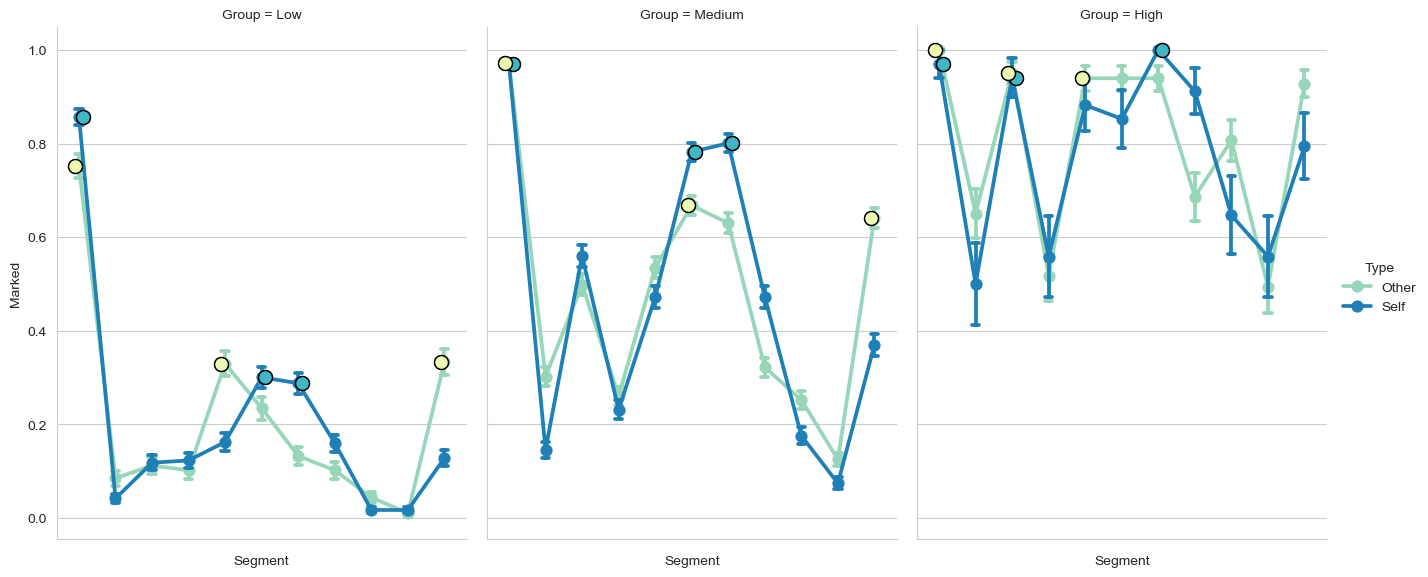

In [300]:
male_df = male_df[male_df["Group"] != "None"].copy()

g = sns.catplot(
    data=male_df, x="Segment", y="Marked", hue="Type", col="Group",
    capsize=.2, palette="YlGnBu", errorbar="se",
    kind="point", height=6, aspect=.75,
    col_order=["Low", "Medium", "High"],
)
segment_order = list(male_df["Segment"].unique())

for ax, group_name in zip(g.axes.flat, ["Low", "Medium", "High"]):
    group_data = male_df[male_df["Group"] == group_name]

    for type_name in ["Self", "Other"]:
        type_data = group_data[group_data["Type"] == "Self"]

        avg_data = (
            type_data
            .groupby(["Segment", "Type"], as_index=False)["Marked"]
            .mean()
        )

        top3 = avg_data.nlargest(3, "Marked")

        for _, row in top3.iterrows():
            segment = row["Segment"]
            y = row["Marked"]
            x = segment_order.index(segment)
            offset = 0.1
            ax.plot(x + offset, y, 'o', color='#41b6c4', markeredgecolor='k', markersize=10, zorder=10)
            # ax.text(x + offset, y, segment)

    for type_name in ["Self", "Other"]:
        type_data = group_data[group_data["Type"] == "Other"]

        avg_data = (
            type_data
            .groupby(["Segment", "Type"], as_index=False)["Marked"]
            .mean()
        )

        top3 = avg_data.nlargest(3, "Marked")

        for _, row in top3.iterrows():
            segment = row["Segment"]
            y = row["Marked"]
            x = segment_order.index(segment)
            offset = 0.1
            ax.plot(x - offset, y, 'o', color='#edf8b1', markeredgecolor='k',
                    markersize=10, zorder=10)
            # ax.text(x + offset, y, segment)

ax.set_xticklabels([])
plt.savefig('output/male-grouped.png', dpi=350, bbox_inches='tight')

plt.show()

In [26]:
model = bmb.Model(
    "Marked ~ Location + Location:Age",
    data=female_density,
    family="poisson"
)

model_fitted = model.fit(draws=2000, target_accept=0.85, idata_kwargs={"log_likelihood": True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Location, Location:Age]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


In [27]:
age = np.linspace(18, 80)
predict_df = pd.DataFrame({
    "Age": np.tile(age, 2),
    "Location": np.repeat(["Front", "Back"], len(age))
})

In [28]:
predict_df["Id"] = 0
model.predict(model_fitted, data=predict_df, sample_new_groups=True)
az.summary(model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.892,0.036,0.827,0.966,0.001,0.000,4334.0,4691.0,1.0
Location[Front],0.470,0.046,0.385,0.558,0.001,0.001,3854.0,4057.0,1.0
Location:Age[Back],-0.005,0.001,-0.008,-0.003,0.000,0.000,4388.0,4974.0,1.0
Location:Age[Front],-0.003,0.001,-0.005,-0.002,0.000,0.000,5189.0,4491.0,1.0
mu[0],3.669,0.053,3.569,3.768,0.001,0.001,5232.0,5561.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[95],1.631,0.084,1.471,1.784,0.001,0.001,4650.0,5022.0,1.0
mu[96],1.620,0.086,1.456,1.775,0.001,0.001,4640.0,5125.0,1.0
mu[97],1.609,0.087,1.454,1.779,0.001,0.001,4632.0,5027.0,1.0
mu[98],1.598,0.089,1.428,1.760,0.001,0.001,4624.0,4961.0,1.0


In [29]:
posterior = az.extract(model_fitted, num_samples=2000)["mu"]

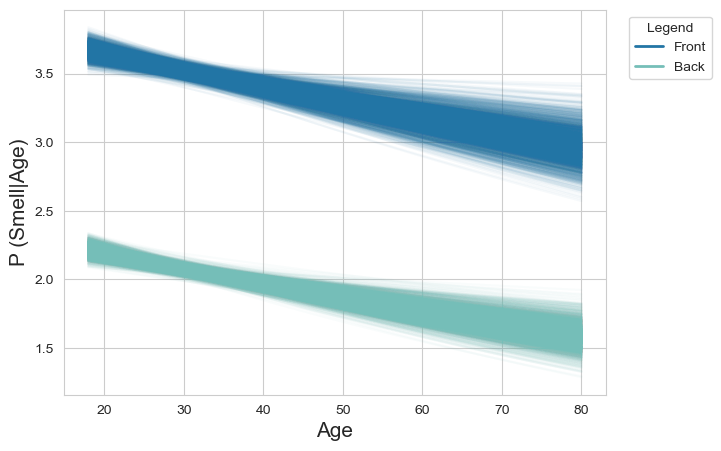

In [30]:
_, ax = plt.subplots(figsize=(7, 5))
for i, location in enumerate(locations):
    idx = predict_df.index[predict_df["Location"] == location].tolist()
ax.plot(age, posterior[idx], alpha=0.04, color=colors[i])

ax.set_ylabel("P (Smell|Age)", fontsize=15)
ax.set_xlabel("Age", fontsize=15)

custom_legend = [
    Line2D([0], [0], color=colors[1], lw=2, label='Front'),
    Line2D([0], [0], color=colors[0], lw=2, label='Back')
]

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1), handles=custom_legend, title="Legend")
plt.savefig('output/stats/prediction_age.png', dpi=350, bbox_inches='tight')
plt.show()

In [31]:
# Logistic mixed-effects model
model = smf.glm(
    "Marked ~ Segment * Gender * Location * Type",
    data=merged,
    family=sm.families.Binomial()
)
model_fit = model.fit()
print(model_fit.summary())

# Reference: Female, Others, armpit
# Intercept -0,0315, p = 0.539 (ns)

# Location (front)   2,585, p < 0.001 (***)
# Type (Self)       -0,321, p < 0.001 (***)
# Gender (Male)     -0,002, p = 0,977 (ns)
# β, p

# There is a significant effect of Type (Self, Other), and Location (Front, Back). However, no significant effect of Gender (Female, Male) is observed
# # Compared to the highest rated Segment, armpit, the rest of the segments were rated significantly lower.
# Segment[T.chest]  -1,167,    p < 0.001 (***)
# Segment[T.feet]   -0,337,    p < 0.001 (***)
# Segment[T.hair]   -1,067,    p < 0.001 (***)
# Segment[T.hand]   -1,621,    p < 0.001 (***)
# Segment[T.legs]   -2,366,    p < 0.001 (***)
# Segment[T.mouth]  -1,954,    p < 0.001 (***)
# Segment[T.neck]   -0,617,    p < 0.001 (***)
# Segment[T.pelvis] -0,362,    p < 0.001 (***)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                77088
Model:                            GLM   Df Residuals:                    77024
Model Family:                Binomial   Df Model:                           63
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40846.
Date:                Fri, 27 Jun 2025   Deviance:                       81691.
Time:                        13:25:53   Pearson chi2:                 7.71e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2008
Covariance Type:            nonrobust                                         
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [32]:
check = pd.crosstab([merged['Segment'], merged['Location']], merged['Marked'])
print(check)

Marked                0     1
Segment  Location            
Armpits  Back      2629  2189
         Front      458  4360
Chest    Back      3996   822
         Front     3750  1068
Feet     Back      3040  1778
         Front     2188  2630
Genitals Back      3010  1808
         Front     2127  2691
Hands    Back      3991   827
         Front     3241  1577
Head     Back      3819   999
         Front     2632  2186
Legs     Back      4505   313
         Front     4552   266
Neck     Back      3667  1151
         Front     3171  1647


In [33]:
# Since there is no difference for gender, lets try to find the difference for segments using Location and Type as factors
# 1. Is there any difference for Females when smelling others?
target1 = (merged[
               (merged['Type'] == 'Other') &
               (merged['Gender'] == 'Female')]
           .copy())

model1 = smf.glm("Marked ~ Segment * Location * Type",
                 data=target1,
                 family=sm.families.Binomial())
model1_fit = model1.fit()
print(model1_fit.summary())

# Compared to the reference segment: Armpit, all other segments were statiscally lower
# Compared to the reference location: Back, the location Front was rated significantly higher.


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Marked   No. Observations:                24384
Model:                            GLM   Df Residuals:                    24368
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13620.
Date:                Fri, 27 Jun 2025   Deviance:                       27240.
Time:                        13:25:53   Pearson chi2:                 2.44e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1896
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [34]:
# # 1. Is there any difference between Female and Male when smelling Others?
# target1 = (merged[
#                (merged['Type'] == 'Other') &
#                (merged['Gender'].isin(['Female', 'Male']))]
#            .copy())
# # same model, only for type others
# model1 = smf.glm("Marked ~ Segment * Location * Gender",
#                  data=target1,
#                  family=sm.families.Binomial())
# model1_fit = model1.fit()
# print(model1_fit.summary())

# Location (front)    0.436, p < 0.001 (***)
# Gender (Male)      -0.001, p = 0.974 (ns)

In [35]:
# contrast_results = []
#
# # Get parameter names from the model
# param_names = model1_fit.params.index
#
# print(param_names)
#
# # Identify all segment levels (excluding reference)
# segment_levels = [name for name in param_names if name.startswith("Segment[T.") and ":Gender" not in name]
#
# all_segments = target1['Segment'].unique()
# test_segments = segment_levels
# ref_segment = 'Armpits'
#
# # Add the reference segment
# segments_to_check = test_segments + [ref_segment]
#
# for seg in segments_to_check:
#     # Initialize contrast vector with zeros
#     contrast_vec = np.zeros(len(param_names))
#
#     # Add 1 for main effect of Gender[T.Male]
#     if "Gender[T.Male]" in param_names:
#         contrast_vec[param_names.get_loc("Gender[T.Male]")] = 1
#
#     # For non-reference segments, add interaction term
#     interaction_term = f"Segment[T.{seg}]:Gender[T.Male]"
#     if interaction_term in param_names:
#         contrast_vec[param_names.get_loc(interaction_term)] = 1
#     # For reference segment (no Segment[T.X] term), no interaction term to add
#
#     # Run the t-test
#     test = model1_fit.t_test(contrast_vec)
#     test_result = test.summary_frame()
#
#     # Store results
#     contrast_results.append({
#         "Segment": seg,
#         "Coef": test_result["coef"].values[0],
#         "StdErr": test_result["std err"].values[0],
#         "z": test_result["z"].values[0],
#         "p_value": test_result["P>|z|"].values[0],
#         "CI_lower": test_result["Conf. Int. Low"].values[0],
#         "CI_upper": test_result["Conf. Int. Upp."].values[0]
#     })
# # #
# # Convert to DataFrame
# contrast_df = pd.DataFrame(contrast_results)
# contrast_df = contrast_df.sort_values("p_value")

# Show the result
# print(contrast_df)

In [36]:
# predict_df = target1.copy()
# predict_df["Id"] = 0  # Dummy ID for prediction
#
# # Predict with fixed effects only (excluding random effects)
# predictions = model1_fit.predict(predict_df)
#
# # Attach predictions
# predict_df["Predicted"] = predictions
#
# g = sns.catplot(
#     data=predict_df, x="Segment", y="Predicted", hue="Location", col="Gender",
#     capsize=.2, palette="YlGnBu_d", errorbar="se",
#     kind="point", height=6, aspect=.75,
# )
# g.despine(left=True)
# plt.show()

# plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
# plt.show()

In [49]:
# # 2. Is there any difference between Female and Male when smelling Themselves?
# target2 = (merged[
#                (merged['Type'] == 'Self') &
#                (merged['Gender'].isin(['Female', 'Male']))]
#            .copy())
# # same model, only for type others
# model2 = smf.mixedlm(
#     "Marked ~ Segment * Location * Gender",
#     target2,
#     groups=target2["Id"]
# )
# model2_fit = model2.fit()
#
# print(model2_fit.summary())

# Location (front)   0.493, p < 0.001 (***)
# Gender (Male)      0.011, p = 0.508 (ns)
# β, p
# Compared to the highest rated Segment, Armpit, the rest of the segments were rated significantly lower when smelling themselves.
# Segment[T.chest]  -0.320,    p < 0.001 (***)
# Segment[T.feet]   -0.067,    p < 0.001 (***)
# Segment[T.hair]   -0.288,    p < 0.001 (***)
# Segment[T.hand]   -0.207,    p < 0.001 (***)
# Segment[T.legs]   -0.370,    p < 0.001 (***)
# Segment[T.mouth]  -0.346,    p < 0.001 (***)
# Segment[T.neck]   -0.291,    p < 0.001 (***)
# Segment[T.pelvis] -0.079,    p < 0.001 (***)

# All segments were rated significantly higher in front.
# Segment[T.chest]:Location[T.Front]   -0.350,   p < 0.001 (***)
# Segment[T.feet]:Location[T.Front]    -0.298,   p < 0.001 (***)
# Segment[T.hair]:Location[T.Front]    -0.419,   p < 0.001 (***)
# Segment[T.hand]:Location[T.Front]    -0.324,   p < 0.001 (***)
# Segment[T.legs]:Location[T.Front]    -0.483,   p < 0.001 (***)
# Segment[T.mouth]:Location[T.Front]   -0.278,   p < 0.001 (***)
# Segment[T.neck]:Location[T.Front]    -0.390,   p < 0.001 (***)
# Segment[T.pelvis]:Location[T.Front]  -0.197,   p < 0.001 (***)

# Gender appears to have no significance overall, although hair was rated significantly higher for females
# Segment[T.Chest]:Gender[T.Male]                     0.006   0.782
# Segment[T.Feet]:Gender[T.Male]                     -0.011   0.617
# Segment[T.Hair]:Gender[T.Male]                     -0.057   0.010 (**)
# Segment[T.Hands]:Gender[T.Male]                    -0.052   0.018
# Segment[T.Legs]:Gender[T.Male]                     -0.010   0.664
# Segment[T.Mouth]:Gender[T.Male]                    -0.019   0.384
# Segment[T.Neck]:Gender[T.Male]                      0.013   0.564
# Segment[T.Pelvis]:Gender[T.Male]                    0.019   0.392
# Location[T.Front]:Gender[T.Male]                   -0.028   0.198

In [50]:
# predict_df = target2.copy()
# predict_df["Id"] = 0  # Dummy ID for prediction
#
# # Predict with fixed effects only (excluding random effects)
# predictions = model2_fit.predict(predict_df)
#
# # Attach predictions
# predict_df["Predicted"] = predictions
#
# g = sns.catplot(
#     data=predict_df, x="Segment", y="Predicted", hue="Location", col="Gender",
#     capsize=.2, palette="YlGnBu_d", errorbar="se",
#     kind="point", height=6, aspect=.75,
# )
# g.despine(left=True)
# plt.show()

# plt.savefig('output/stats/pointplot-others-gender.png', bbox_inches='tight', dpi=300)
# plt.show()

In [39]:
# # 3. is there any difference when Males smell themselves vs when they smell Others?
# target3 = (merged[
#                (merged['Gender'] == 'Male')
#            ]
#            .copy())
# # same model, only for type others
# model3 = smf.mixedlm(
#     "Marked ~ Segment * Location * Type",
#     target3,
#     groups=target3["Id"]
# )
# model3_fit = model3.fit()
#
# print(model3_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.084    p = 0.001 (***)
# Segment[T.Feet]:Type[T.Self]                      0.050    p = 0.055
# Segment[T.Hair]:Type[T.Self]                     -0.014    p = 0.601
# Segment[T.Hands]:Type[T.Self]                     0.095    p < 0.001 (***)
# Segment[T.Legs]:Type[T.Self]                      0.019    p = 0.459
# Segment[T.Mouth]:Type[T.Self]                     0.015    p = 0.571
# Segment[T.Neck]:Type[T.Self]                     -0.140    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.021    p = 0.408
# Location[T.Front]:Type[T.Self]                    0.075    p = 0.004 (**)

# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.037    p = 0.309
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.052    p = 0.156
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.138    p < 0.001 (***)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.043    p = 0.242
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.058    p = 0.116
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.073    p = 0.045 (*)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.132    p < 0.001 (***)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.043    p = 0.242

In [40]:
# predict_df = target3.copy()
# predict_df["Id"] = 0  # Dummy ID for prediction
#
# # Predict with fixed effects only (excluding random effects)
# predictions = model3_fit.predict(predict_df)
#
# # Attach predictions
# predict_df["Predicted"] = predictions

# sns.pointplot(
#     data=predict_df,
#     x="Segment",
#     hue="Type",
#     y="Predicted",
#     errorbar="sd",
#     palette='YlGnBu'
# )
# plt.title("Predicted Ratings by Segment and Location (Males)")
# plt.ylabel("Estimated Rating (Fixed Effects Only)")
# plt.savefig('output/stats/pointplot-others-location.png', bbox_inches='tight', dpi=300)
# plt.show()
#
# g = sns.catplot(
#     data=predict_df, x="Segment", y="Predicted", hue="Type", col="Location",
#     capsize=.2, palette="YlGnBu_d", errorbar="se",
#     kind="point", height=6, aspect=.75,
# )
# g.despine(left=True)
# plt.show()

In [41]:
# # 4. is there any difference when Females smell themselves vs when they smell Others?
# target4 = (merged[
#                (merged['Gender'] == 'Female')
#            ]
#            .copy())
# model4 = smf.mixedlm(
#     "Marked ~ Segment * Location * Type",
#     target4,
#     groups=target4["Id"]
# )
# model4_fit = model4.fit()
#
# print(model4_fit.summary())

# Segment[T.Chest]:Type[T.Self]                    -0.060    p = 0.003 (**)
# Segment[T.Feet]:Type[T.Self]                      0.016    p = 0.412
# Segment[T.Hair]:Type[T.Self]                     -0.009    p = 0.669
# Segment[T.Hands]:Type[T.Self]                     0.125    p < 0.001 (**)
# Segment[T.Legs]:Type[T.Self]                      0.039    p = 0.053
# Segment[T.Mouth]:Type[T.Self]                     0.026    p = 0.200
# Segment[T.Neck]:Type[T.Self]                     -0.142    p < 0.001 (***)
# Segment[T.Pelvis]:Type[T.Self]                    0.010    p = 0.599
# Location[T.Front]:Type[T.Self]                    0.057    p = 0.004 (**)
#
# Segment[T.Chest]:Location[T.Front]:Type[T.Self]   0.097    p = 0.001 (**)
# Segment[T.Feet]:Location[T.Front]:Type[T.Self]   -0.045    p = 0.109
# Segment[T.Hair]:Location[T.Front]:Type[T.Self]   -0.087    p = 0.002 (**)
# Segment[T.Hands]:Location[T.Front]:Type[T.Self]  -0.048    p = 0.090
# Segment[T.Legs]:Location[T.Front]:Type[T.Self]   -0.022    p = 0.443
# Segment[T.Mouth]:Location[T.Front]:Type[T.Self]  -0.083    p = 0.003 (**)
# Segment[T.Neck]:Location[T.Front]:Type[T.Self]   -0.071    p = 0.012 (*)
# Segment[T.Pelvis]:Location[T.Front]:Type[T.Self]  0.117    p < 0.001 (***)

In [42]:
# # 5. Comparing the body as whole, is there any difference between Female and Males when smelling themselves in front and back, and what about when smelling Others?
# target5 = (merged[
#                (merged['Type'].isin(['Self', 'Other'])) &
#                (merged['Gender'].isin(['Female', 'Male']))]
#            .copy())
# model5 = smf.mixedlm(
#     "Marked ~ Gender * Location * Type",
#     target5,
#     groups=target5["Id"]
# )
# model5_fit = model5.fit()
#
# print(model5_fit.summary())

# Effect of location (Front - Back)
# β = 0.147, p < 0.0001 (***)

# Effect of Gender (Female - Male)
# β = -0.008, p = 0.328 (ns)

# Effect of Location and type
# Location[T.Front]:Type[T.Self]  β = 0.041, p < 0.0001 (***)

In [43]:
# # 6. Where do Females prefer to smell themselves (Front)
# new_merge = merged[merged['Segment'] != "Armpits"]
#
# target6 = new_merge[
#     (new_merge['Location'] == 'Front') &
#     (new_merge['Gender'] == 'Male') &
#     (new_merge['Type'] == 'Self')
#     ].copy()
#
# model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
# print(model6.summary())
#
# target6 = new_merge[
#     (new_merge['Location'] == 'Front') &
#     (new_merge['Gender'] == 'Male') &
#     (new_merge['Type'] == 'Other')
#     ].copy()
#
# model6 = smf.glm('Marked ~ Segment', data=new_merge, family=sm.families.Binomial()).fit()
# print(model6.summary())

In [44]:
# # 3. What are the odds for females to smell others?
# target3 = (merged[
#               (merged['Gender']== 'Female')]
#           .copy())

In [45]:
# # y = 1 if the person marks Front
# # y = 0 if the person marks back
# #
# # x1 = 1 if segment is armpit, 0 otherwise
# # x2 = 1 if segment is chest, 0 otherwise
# # xn = 1 if segment is n, 0 otherwise
#
# model3 = bmb.Model("Marked['1'] ~ Location + Location:Type", data=target3, family="bernoulli")
# model3_fit = model3.fit(draws=2000, target_accept=0.85, idata_kwargs={"log_likelihood": True})

In [46]:
# az.summary(model3_fit)

In [47]:
# locations = ["Front, Self", "Back, Self"]
# dem, ind = [model3_fit.posterior["Location:Type"].sel({"Location:Type_dim":location}) for location in locations]

In [48]:
# _, ax = plt.subplots()
# for idx, x in enumerate([dem, ind]):
#     az.plot_dist(x, label=x["Location:Type_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
# ax.legend(loc="upper left");